# Loan

## 0 Imports

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from classifierConfigs import get_classifier_configs, get_scorings, model_requires_int_labels

# Silence noisy worker warnings
import os, warnings
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated as an API.*", category=UserWarning)
os.environ.setdefault("PYTHONWARNINGS", "ignore:pkg_resources is deprecated as an API:UserWarning")

'ignore:pkg_resources is deprecated as an API:UserWarning'

## 1 Load and first look

### 1.1 Dataset Description

The dataset **Loan** can be used to predict the class of a loan grade. The dataset is given as a csv file and will be imported via pandas.

It includes
- **loan-10k.lrn.csv**: training dataset
- **loan-10k.tes.csv**: test/validation dataset
- **loan-10k.sol.ex.csv**: sample solutions

In [68]:
datafolder = "../../datasets/Loan"

training_file = f"{datafolder}/loan-10k.lrn.csv"
test_file = f"{datafolder}/loan-10k.tes.csv"
solution_file = f"{datafolder}/loan-10k.sol.ex.csv"

training_df = pd.read_csv(training_file)
test_df = pd.read_csv(test_file)

print(f"""
Dataset name: Loan
Abstract: 
Task: Multiclass classification
The training dataset has following properties:
    - Number of Instances: {training_df.shape[0]}
    - Number of Features: {training_df.shape[1]-1}
    - Number of Target Attributes: 1
    - Number of Dimensions: {training_df.ndim}
    - Has missing values: {'yes' if training_df.isnull().sum().sum() > 0 else 'no'}
    - Types of attributes: {training_df.dtypes.value_counts().to_dict()}
    - Duplicate Instances: {training_df.duplicated().sum()}
The validation dataset has following properties:
    - Number of Instances: {test_df.shape[0]}
    - Has missing values: {'yes' if test_df.isnull().sum().sum() > 0 else 'no'}
    - Duplicate Instances: {test_df.duplicated().sum()}
""")


Dataset name: Loan
Abstract: 
Task: Multiclass classification
The training dataset has following properties:
    - Number of Instances: 10000
    - Number of Features: 91
    - Number of Target Attributes: 1
    - Number of Dimensions: 2
    - Has missing values: no
    - Types of attributes: {dtype('float64'): 69, dtype('O'): 14, dtype('int64'): 9}
    - Duplicate Instances: 0
The validation dataset has following properties:
    - Number of Instances: 10000
    - Has missing values: no
    - Duplicate Instances: 0



In [69]:
training_df.head()

,ID,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,...,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,grade
0,24341,12500.0,12500.0,12500.0,36 months,7.21,387.17,< 1 year,MORTGAGE,81000.0,...,N,6,2018,6,2000,2,2019,2,2019,A
1,67534,33850.0,33850.0,33775.0,60 months,20.99,915.57,1 year,MORTGAGE,80000.0,...,N,10,2015,9,1984,2,2019,2,2019,E
2,35080,10000.0,10000.0,10000.0,60 months,20.00,264.94,< 1 year,RENT,36580.0,...,N,9,2017,10,2006,1,2018,11,2018,D
3,4828,20250.0,20250.0,20250.0,36 months,14.31,695.15,9 years,RENT,48700.0,...,N,0,2015,6,1996,6,2016,9,2017,C
4,59259,25000.0,25000.0,25000.0,36 months,14.99,866.52,1 year,MORTGAGE,85000.0,...,N,11,2016,0,2002,2,2019,2,2019,C


### 1.2 Attributes

In [70]:
print(f"{'Attribute':<25} {'Data Type':<10} {'Missing Values':<15} {'Min':<10} {'Max'}")
print("-" * 70)
for col in training_df.columns:
    if training_df[col].dtype in [np.int64, np.float64]:
        print(f"{col:<25} {str(training_df[col].dtype):<10} {training_df[col].isnull().sum():<15} {training_df[col].min():<10} {training_df[col].max()}")
    else:
        print(f"{col:<25} {str(training_df[col].dtype):<10} {training_df[col].isnull().sum():<15} {'n.a.':<10} {'n.a.':<10} {set(training_df[col].values)}") 

Attribute                 Data Type  Missing Values  Min        Max
----------------------------------------------------------------------
ID                        int64      0               0          99999
loan_amnt                 float64    0               1000.0     40000.0
funded_amnt               float64    0               1000.0     40000.0
funded_amnt_inv           float64    0               1000.0     40000.0
term                      object     0               n.a.       n.a.       {' 36 months', ' 60 months'}
int_rate                  float64    0               5.31       30.99
installment               float64    0               30.12      1717.63
emp_length                object     0               n.a.       n.a.       {'2 years', '10+ years', '1 year', '6 years', '4 years', '9 years', '< 1 year', '3 years', '7 years', '8 years', '5 years'}
home_ownership            object     0               n.a.       n.a.       {'RENT', 'OWN', 'ANY', 'OTHER', 'MORTGAGE'}
annual_inc 

#### 1.2.1 Description & Data Types

- `ID` (_Integer_): Each record has a unique identifier, which is not a predictive feature but used for reference.
- `grade` (_Object_): **Target attribute** indicating the loan score. Training dataset contains values between A and G.

**Numerical attributes** (selection)
- `loan_amount`, `funded_amnt`, `funded_amnt_inv`
- `int_rate`
- `installment`
- `annual_inc`
- `dti`
- `delinq_2yrs`
- `fico_range_low`, `fico_range_high`, `last_fico_range_high`, `last_fico_range_low`
- `inq_las_6mths`
- `open_acc`
- `pub_rec`
- `revol_bal`, `revol_util`
- `total_acc`
- `out_prncp`, `out_prncp_inv`
- `total_pymnt`, `total_pymnt_inv`, `last_pymnt_amnt`
- `total_rec_prncp`, `total_rec_int`, `total_rec_late_fee`
- `recoveries`
- `collection_recovery_fee`

**Categorical attributes**: 
- `term`
- `emp_length`
- `home_ownership`
- `verification_status`
- `loan_status`
- `pymnt_plan`
- `purpose`
- `addr_state`
- `initial_list_status`
- `hardship_flag`
- `disbursement_method`
- `debt_settlement_flag`

Some features are stored as objects (categorical) altough they are binary, those will be transformed to a binary column. Some features are stored as objects, although they can be translated to a numerical feature, those will be transformed to nurmical features. This will be handeld in the data cleaning section.


In [71]:
len(training_df.columns)

92

## 2 Data Cleaning

### 2.1 Datatypes

In [72]:
originally_numerical_features = training_df.select_dtypes(include=[np.number]).columns.tolist()
originally_categorical_features = training_df.select_dtypes(include=['object']).columns.tolist()
originally_categorical_features.remove('grade')  # Remove target variable from features list
categorical_mappings = {}
for col in originally_categorical_features:
    categorical_mappings[col] = training_df[col].unique().tolist()

In [73]:
# Columsn that are actually binary but stored as objects (categorical)
new_binary_features = {
    # "old name":
    # {
    #     "name of positive": "new value representing positive class",
    #     "name of negative": "new value representing negative class"
    # }
    "pymnt_plan":
        {
            'n': False,
            'y': True
        },
    "initial_list_status":
        {
            'f': False,
            'w': True
        },
    "hardship_flag":
        {
            'N': False,
            'Y': True
        },
    "debt_settlement_flag":
        {
            'N': False,
            'Y': True
        }
}
new_numerical_features = {
    "term": {
        ' 36 months': 36,
        ' 60 months': 60
    },
}

emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

verification_status_mapping = {
    'Not Verified': 0,
    'Source Verified': 1,
    'Verified': 2
}


In [74]:
len(training_df.columns)

92

In [75]:
#remap categorical to binary and add suffix
for col, mapping in new_binary_features.items():
    training_df[col + "_bin"] = training_df[col].map(mapping)
    training_df.drop(columns=[col], inplace=True)
    test_df[col + "_bin"] = test_df[col].map(mapping)
    test_df.drop(columns=[col], inplace=True)


In [76]:
#remap categorical to numerical
for col, mapping in new_numerical_features.items():
    training_df[col] = training_df[col].map(mapping)
    test_df[col] = test_df[col].map(mapping)

In [77]:
#remap categorical mappings
training_df['emp_length'] = training_df['emp_length'].map(emp_length_mapping)
test_df['emp_length'] = test_df['emp_length'].map(emp_length_mapping)

In [78]:
#remap verification_status
training_df['verification_status'] = training_df['verification_status'].map(verification_status_mapping)
test_df['verification_status'] = test_df['verification_status'].map(verification_status_mapping)

In [79]:
# Create combined date features
# For issue_d: time since the loan was issued (in months from a reference point)
training_df['issue_d_months_since_reference'] = (training_df['issue_d_year'] - 2012) * 12 + training_df['issue_d_month']
test_df['issue_d_months_since_reference'] = (test_df['issue_d_year'] - 2012) * 12 + test_df['issue_d_month']

# For earliest_cr_line: credit history age at time of loan
training_df['credit_history_age'] = (training_df['issue_d_year'] - training_df['earliest_cr_line_year']) * 12 + \
                                     (training_df['issue_d_month'] - training_df['earliest_cr_line_month'])
test_df['credit_history_age'] = (test_df['issue_d_year'] - test_df['earliest_cr_line_year']) * 12 + \
                                 (test_df['issue_d_month'] - test_df['earliest_cr_line_month'])

# Drop original date columns
training_df.drop(columns=['issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year'], inplace=True)
test_df.drop(columns=['issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year'], inplace=True)

### 2.2 Remove non informative variables
**policy_code** only has 1.0 as a single value. Remove this

In [80]:
training_df["policy_code"].value_counts()

policy_code
1.0    10000
Name: count, dtype: int64

In [81]:
training_df.drop(columns=["policy_code"], inplace=True)
test_df.drop(columns=["policy_code"], inplace=True)

### 2.3 Missing Values and Duplicates
As already mentioned, there ar luckily no missing variables and also no duplicates

In [82]:
print(f"""
Missing values in training set: {training_df.isnull().sum().sum()}
Missing values in test set: {test_df.isnull().sum().sum()}
Duplicate instances in training set: {training_df.duplicated().sum()}
Duplicate instances in test set: {test_df.duplicated().sum()}
""")


Missing values in training set: 0
Missing values in test set: 0
Duplicate instances in training set: 0
Duplicate instances in test set: 0



### 2.4 Summary

In [83]:
# (Initial summary — will be recomputed after cleanup too)
numerical_feature_names = training_df.select_dtypes(include=[np.number]).columns.tolist()
# include both Python bool and pandas nullable Boolean
binary_feature_names = training_df.select_dtypes(include=['bool', 'boolean']).columns.tolist()
categorical_feature_names = training_df.select_dtypes(include=['category', 'object']).columns.tolist()
if 'grade' in categorical_feature_names:
    categorical_feature_names.remove('grade')  # Remove target variable from features list

In [84]:
print(f"""
After preprocessing, the training dataset has:
    - Rows: {training_df.shape[0]}
    - Features (excluding target): {training_df.shape[1]-1}
        - Numerical: {len(numerical_feature_names)}
        - Binary: {len(binary_feature_names)}
        - Categorical: {len(categorical_feature_names)}
Target classes: {sorted(training_df['grade'].unique())}
""")


After preprocessing, the training dataset has:
    - Rows: 10000
    - Features (excluding target): 88
        - Numerical: 78
        - Binary: 4
        - Categorical: 6
Target classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G']



## 3 Visualisations

### 3.1 Target Visualizations

/tmp/ipykernel_546533/2889015546.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='grade', data=training_df, order=sorted(training_df['grade'].unique()), palette='Set2')


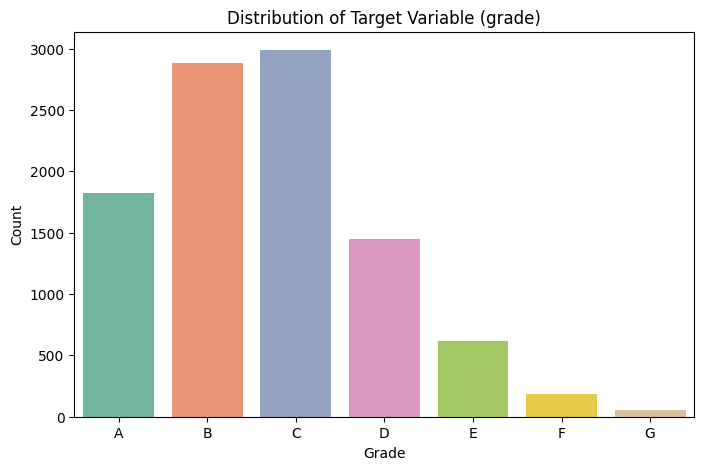

In [85]:
# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='grade', data=training_df, order=sorted(training_df['grade'].unique()), palette='Set2')
plt.title('Distribution of Target Variable (grade)')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

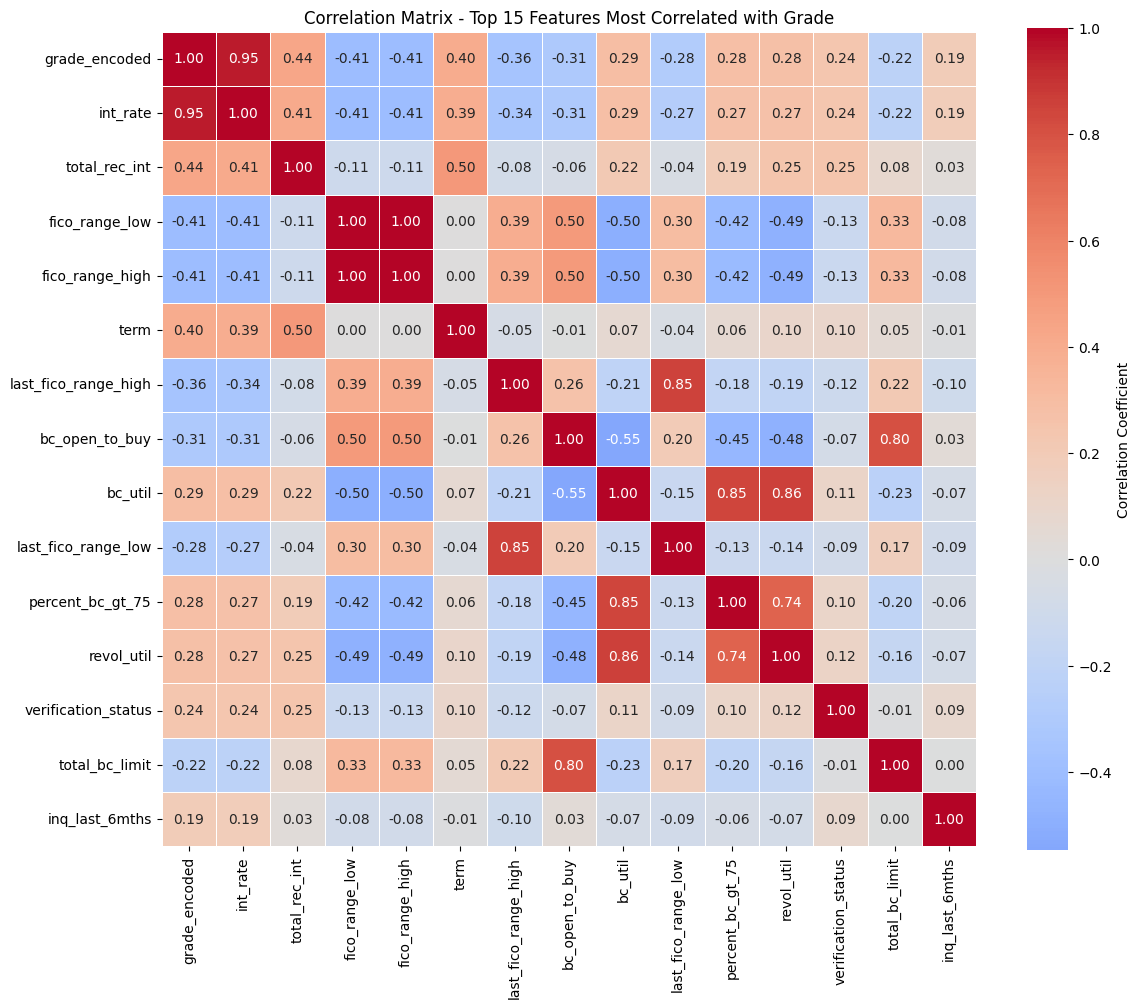

In [86]:
temp_df = training_df.copy()
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
temp_df['grade_encoded'] = temp_df['grade'].map(grade_mapping)

# Compute correlation matrix
correlation_matrix = temp_df[numerical_feature_names + ['grade_encoded']].corr()

# Select top N features most correlated with grade for visualization
top_n = 15
top_features = correlation_matrix['grade_encoded'].abs().sort_values(ascending=False).head(top_n).index.tolist()

# Plot correlation heatmap for top features
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix.loc[top_features, top_features], 
    annot=True, 
    fmt='.2f',
    cmap='coolwarm', 
    center=0, 
    square=True, 
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title(f'Correlation Matrix - Top {top_n} Features Most Correlated with Grade')
plt.tight_layout()
plt.show()

### 3.2 Feature Visualizations

In [87]:
top_10_correlated_features = correlation_matrix['grade_encoded'].abs().sort_values(ascending=False).head(10).index.tolist()

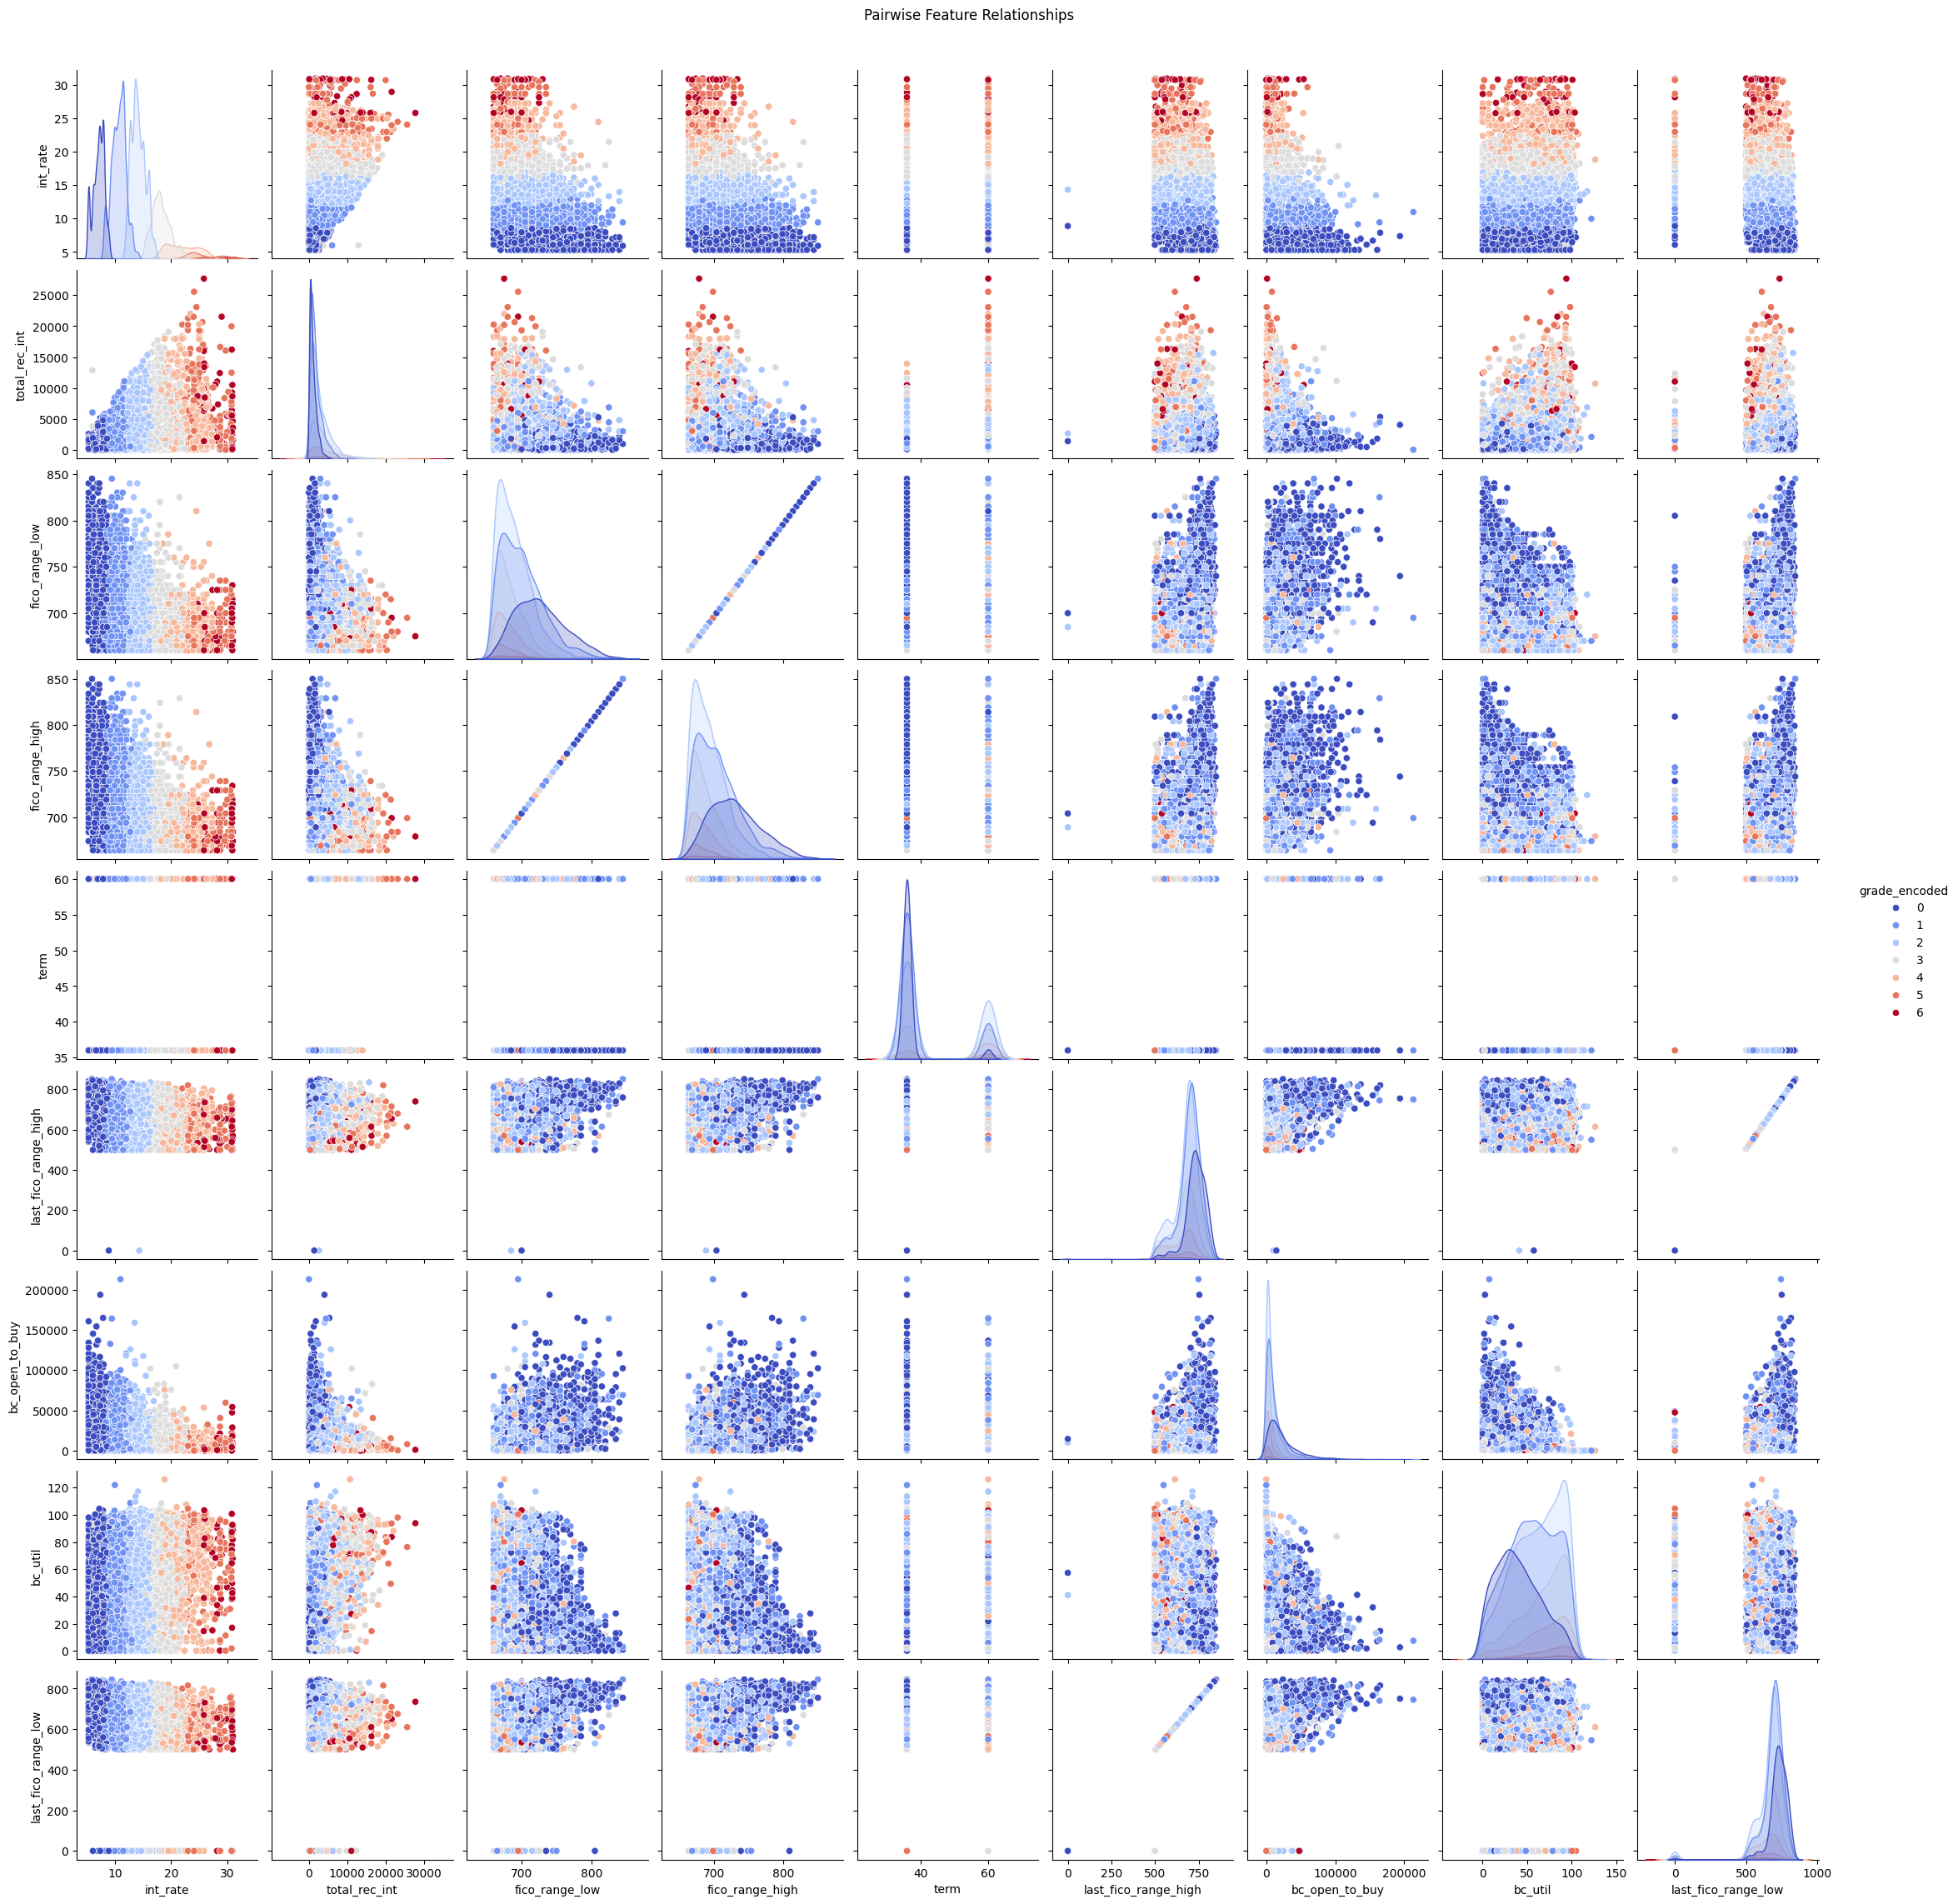

In [88]:
sns.pairplot(temp_df[top_10_correlated_features], hue='grade_encoded', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships', y=1.02)
plt.show()

In [89]:
def suggest_highly_corr_columns(df, target = "grade_encoded", threshold=0.95):
    """
    Returns highly correlated feature columns above the specified threshold.
    To then decide which to drop.
    """
    
    corr_matrix = df.corr(numeric_only=True).abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    #to_drop dataframe with correlation values
    to_drop = []
    for column in upper_triangle.columns:
        high_corr = upper_triangle.index[upper_triangle[column] > threshold].tolist()
        for row in high_corr:
            to_drop.append((row, column, upper_triangle.at[row, column]))
    
    #suggest to drop the one with lower correlation with target variable
    #map grade to numerical for correlation calculation
    if df[target].dtype == 'object':
        df[target] = df[target].astype('category').cat.codes
    final_to_drop = set()
    for col1, col2, corr_value in to_drop:
        corr_with_target_col1 = abs(df[col1].corr(df[target]))
        corr_with_target_col2 = abs(df[col2].corr(df[target]))
        if corr_with_target_col1 < corr_with_target_col2:
            final_to_drop.add(col1)
        else:
            final_to_drop.add(col2)
    #print the columns that correlate with their correlation value and return the columns to drop
    print("Highly correlated columns (above threshold):")
    for col1, col2, corr_value in to_drop:
        print(f"{col1} | {col2} | {corr_value:.2f}")
    return final_to_drop

suggest_highly_corr_columns(temp_df, target="grade_encoded", threshold=0.95)

Highly correlated columns (above threshold):
loan_amnt | funded_amnt | 1.00
loan_amnt | funded_amnt_inv | 1.00
funded_amnt | funded_amnt_inv | 1.00
fico_range_low | fico_range_high | 1.00
out_prncp | out_prncp_inv | 1.00
total_pymnt | total_pymnt_inv | 1.00
total_pymnt | total_rec_prncp | 0.97
total_pymnt_inv | total_rec_prncp | 0.97
recoveries | collection_recovery_fee | 0.98
num_actv_rev_tl | num_rev_tl_bal_gt_0 | 1.00
open_acc | num_sats | 1.00
tot_cur_bal | tot_hi_cred_lim | 0.98
int_rate | grade_encoded | 0.95


{'collection_recovery_fee',
 'fico_range_high',
 'funded_amnt',
 'int_rate',
 'loan_amnt',
 'num_actv_rev_tl',
 'open_acc',
 'out_prncp_inv',
 'tot_cur_bal',
 'total_pymnt',
 'total_rec_prncp'}

In [90]:
#remove highly correlated columns
# training_df.drop(columns=highly_corr_cols, inplace=True)
# test_df.drop(columns=highly_corr_cols, inplace=True)

# Not removing because for our best Model (Random Forest) we would just loose information!

### 3.2 Outlier Detection and Visualization

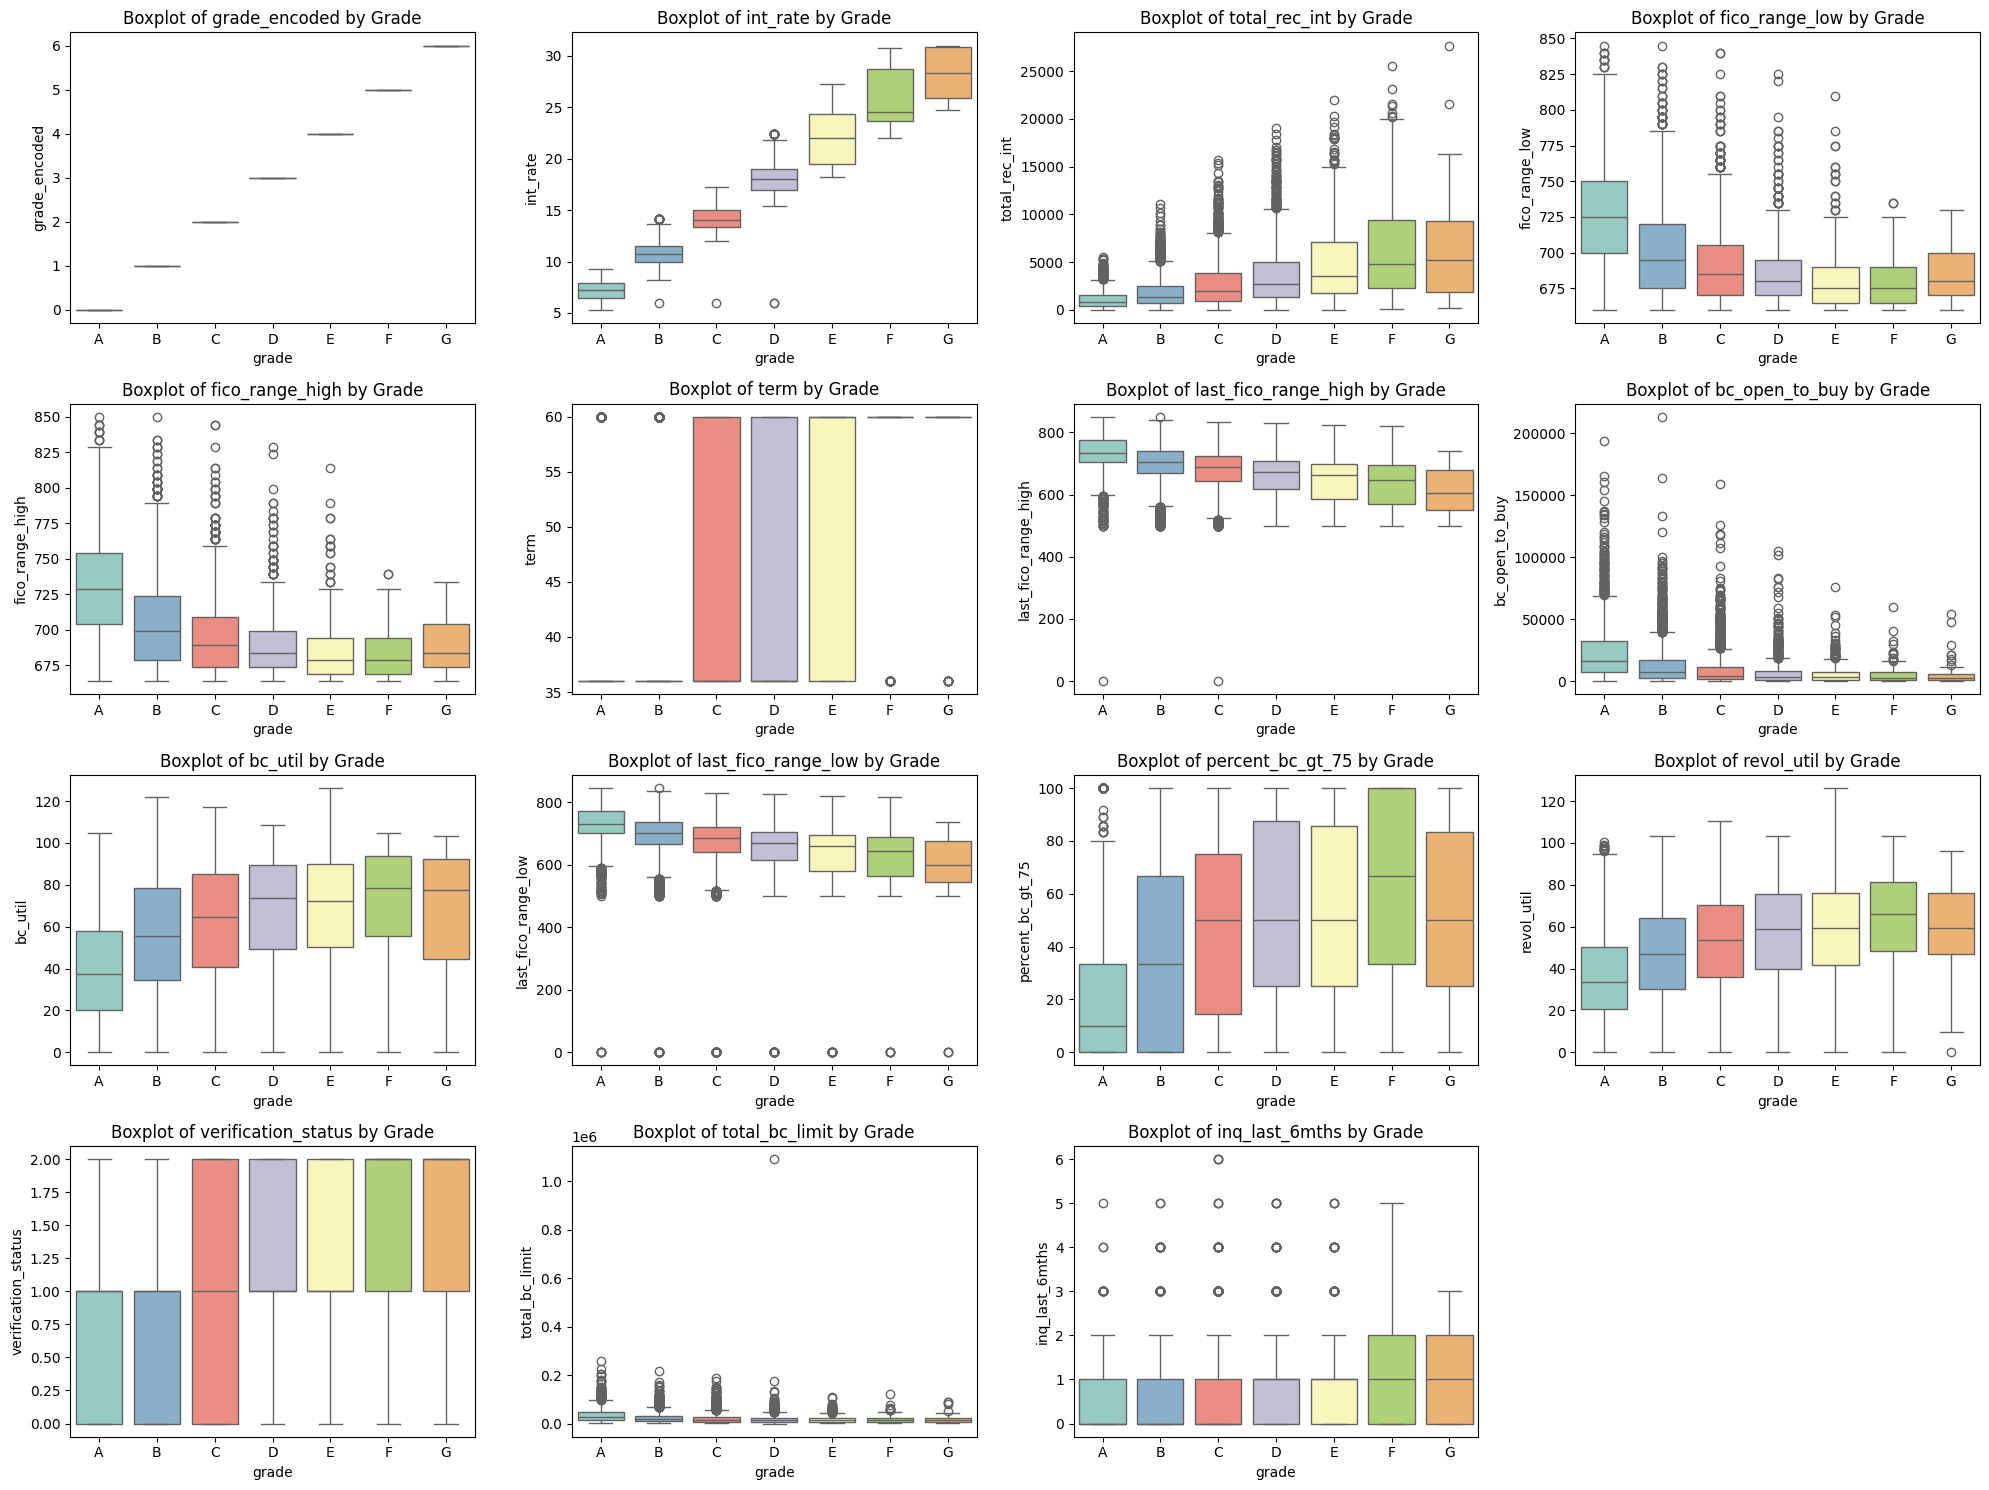

In [91]:
# Visualize outliers in top features using boxplots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(top_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='grade', y=feature, data=temp_df, hue='grade', 
                palette='Set3', legend=False, 
                order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
    plt.title(f'Boxplot of {feature} by Grade')
    plt.tight_layout()
plt.show()

Won't remove outliers. They can have important effects. On the target variables and Tree based methods, especially forests can treat them well.

## 4 Preprocessing

### 4.1 Prepare & Split Dataset

- Separate target attribute from features 
- Remove `ID`

In [92]:
X = training_df.drop(['ID', 'grade'], axis=1)
y = training_df['grade']

# Split data (stratified to preserve class distribution)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 4.2 Preprocessing Pipeline

In [93]:
num_features = [f for f in numerical_feature_names if f in X_train.columns]
cat_features = [f for f in categorical_feature_names if f in X_train.columns]
bin_features = [f for f in binary_feature_names if f in X_train.columns]

def make_preprocessor(scale: bool):
    num_transformer = StandardScaler() if scale else 'passthrough'
    return ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
            ('bin', 'passthrough', bin_features)
        ],
        remainder='drop'
    )

## 5 Model Selection and Hyperparameter Experimentation

### 5.1 Find best Hyperparameters with Grid Search

In [94]:
# Task selection: 'multiclass' or 'binary'
task = 'multiclass'

# Label encoding for multiclass XGBoost only
grade_to_int = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6}
int_to_grade = {v:k for k,v in grade_to_int.items()}
y_train_int = y_train.map(grade_to_int)
y_val_int = y_val.map(grade_to_int)

# Multi-metric scoring and configs by task
scoring = get_scorings(multiclass=(task == 'multiclass'))
refit_metric = "f1_macro"
configs = get_classifier_configs(task=task)

results_dir = "loan/gridsearch"
os.makedirs(results_dir, exist_ok=True)
all_results = []

for name, cfg in configs.items():
    print(f"Running Grid Search for {name}...")
    scale_TF = name.lower().startswith('knn')  # Scale only for KNN
    pipe = Pipeline(steps=[
        ('preprocessor', make_preprocessor(scale=scale_TF)),
        ('classifier', cfg['model'])
    ])

    param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        n_jobs=6,
        verbose=3,
        cv=3
    )

    y_fit = y_train_int if (task == 'multiclass' and model_requires_int_labels(name)) else y_train
    gs.fit(X_train, y_fit)

    # Save per-model CV results
    res_df = pd.DataFrame(gs.cv_results_)
    rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
    if rank_col is not None:
        res_df = res_df.sort_values(rank_col)
    res_df.insert(0, 'model', name)
    res_df.insert(1, 'scoring', refit_metric)
    res_df['preproc_scaled'] = scale_TF
    out_path = os.path.join(results_dir, f"{name.replace(' ', '_')}_cv_results_{refit_metric}.csv")
    res_df.to_csv(out_path, index=False)
    all_results.append(res_df)

    print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

    # Predict and decode if needed
    y_val_pred = gs.predict(X_val)
    if task == 'multiclass' and model_requires_int_labels(name):
        y_val_pred = pd.Series(y_val_pred).map(int_to_grade).values

    print(f"Validation Classification Report for {name}:\n")
    print(classification_report(y_val, y_val_pred, zero_division=0))
    print("-" * 80)

if all_results:
    pd.concat(all_results, ignore_index=True).to_csv(
        os.path.join(results_dir, f"Loan_ALL_cv_results_{refit_metric}.csv"),
        index=False
    )

Running Grid Search for KNN...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 3/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.407) f1_macro: (test=0.234) precision_macro: (test=0.262) recall_macro: (test=0.254) total time=   0.9s
[CV 1/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=distance; accuracy: (test=0.417) f1_macro: (test=0.294) precision_macro: (test=0.302) recall_macro: (test=0.290) total time=   0.9s
[CV 3/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=distance; accuracy: (test=0.412) f1_macro: (test=0.292) precision_macro: (test=0.313) recall_macro: (test=0.286) total time=   0.9s
[CV 2/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.435) f1_macro: (test=0.259) precision_macro: (test=0.297) recall_macro: (test=0.274) total time=   1.0s
[CV 1/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weigh

### 5.2 Visualize effects of altering Hyperparameters

In [95]:
results_dir = "loan/gridsearch"
file = "Loan_ALL_cv_results_f1_macro.csv"
all_results = pd.read_csv(os.path.join(results_dir, file))

In [96]:
all_results.shape
randomForest_results = all_results[all_results['model'] == 'Random Forest']
#if max_depth is nan, fill with 0
randomForest_results["param_classifier__max_depth"] = randomForest_results["param_classifier__max_depth"].where(
	pd.notnull(randomForest_results["param_classifier__max_depth"]), 0
)
XGBoost_results = all_results[all_results['model'] == 'XGBoost']
KNN_results = all_results[all_results['model'] == 'KNN']


/tmp/ipykernel_546533/2660028580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomForest_results["param_classifier__max_depth"] = randomForest_results["param_classifier__max_depth"].where(


In [97]:
randomForest_params = ["param_classifier__n_estimators", "param_classifier__max_depth"]
XGBoost_params = ["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__learning_rate"]
KNN_params = ["param_classifier__n_neighbors", "param_classifier__weights", "param_classifier__p"]

In [98]:
randomForest_results["param_classifier__max_depth"]

16     10.0
17      0.0
18    100.0
19      0.0
20    100.0
21     10.0
22      0.0
23    100.0
24      0.0
25     10.0
26    100.0
27     10.0
Name: param_classifier__max_depth, dtype: float64

In [99]:
randomForest_best = randomForest_results.loc[randomForest_results['rank_test_f1_macro'] == 1].iloc[0]
randomForest_best_params = {
    'n_estimators': randomForest_best['param_classifier__n_estimators'].astype(int),
    'max_depth': randomForest_best['param_classifier__max_depth'].astype(int)
}
XGBoost_best = XGBoost_results.loc[XGBoost_results['rank_test_f1_macro'] == 1].iloc[0]
XGBoost_best_params = {
    'n_estimators': XGBoost_best['param_classifier__n_estimators'].astype(int),
    'max_depth': XGBoost_best['param_classifier__max_depth'].astype(int),
    'learning_rate': XGBoost_best['param_classifier__learning_rate']
}
KNN_best = KNN_results.loc[KNN_results['rank_test_f1_macro'] == 1].iloc[0]
KNN_best_params = {
    'n_neighbors': KNN_best['param_classifier__n_neighbors'].astype(int),
    'weights': KNN_best['param_classifier__weights'],
    'p': KNN_best['param_classifier__p'].astype(int)
}

def plot_hyperparameter_effects(results_df, model_name, hyperparams, best_params):
    n = len(hyperparams)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axs = axs[0]

    for i, param in enumerate(hyperparams):
        ax = axs[i]
        subset = results_df.copy()
        for other_param in hyperparams:
            if other_param != param:
                subset = subset[
                    subset[other_param] == best_params[other_param.replace('param_classifier__', '')]
                ]

        sub = subset.dropna(subset=[param, 'mean_test_f1_macro'])
        is_numeric = pd.api.types.is_numeric_dtype(sub[param])
        if not is_numeric:
            coerced = pd.to_numeric(sub[param], errors='coerce')
            if coerced.notna().sum() == len(sub):
                sub[param] = coerced
                is_numeric = True

        if is_numeric:
            sub = sub.sort_values(by=param)
            sns.lineplot(data=sub, x=param, y='mean_test_f1_macro', marker='o', ax=ax)
        else:
            sns.barplot(data=sub, x=param, y='mean_test_f1_macro', ax=ax)
            ax.tick_params(axis='x', rotation=45)

        clean_name = param.replace('param_classifier__', '')
        ax.set_title(clean_name)
        ax.set_xlabel(clean_name)
        if i == 0:
            ax.set_ylabel('Mean F1 Macro')
        else:
            ax.set_ylabel('')
        ax.grid(True, linestyle='--', alpha=0.4)

    fig.suptitle(f'Hyperparameter effects for {model_name}', y=1.03)
    fig.tight_layout()

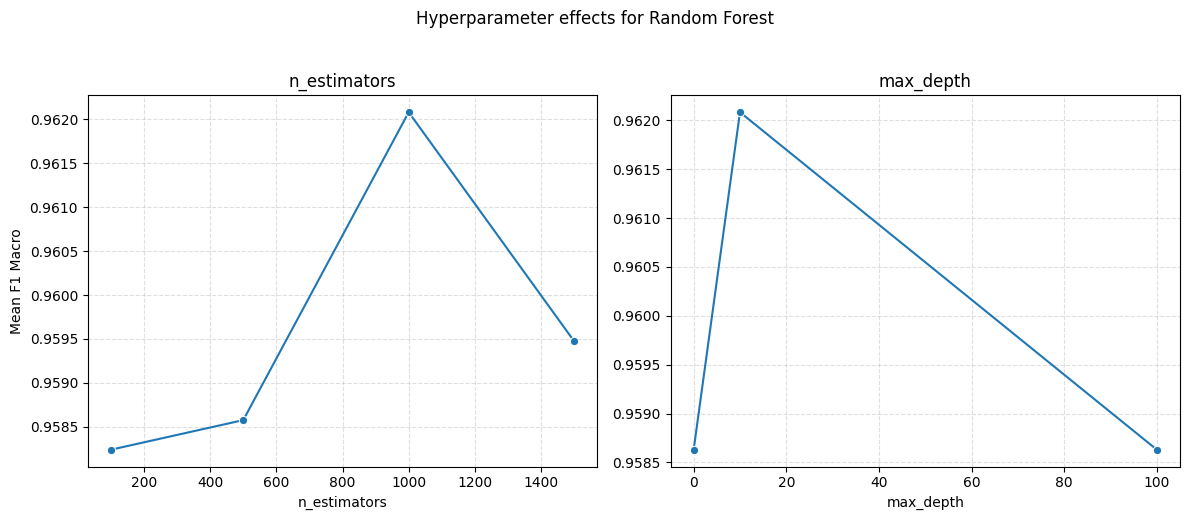

In [100]:
plot_hyperparameter_effects(randomForest_results, 'Random Forest', randomForest_params, randomForest_best_params)

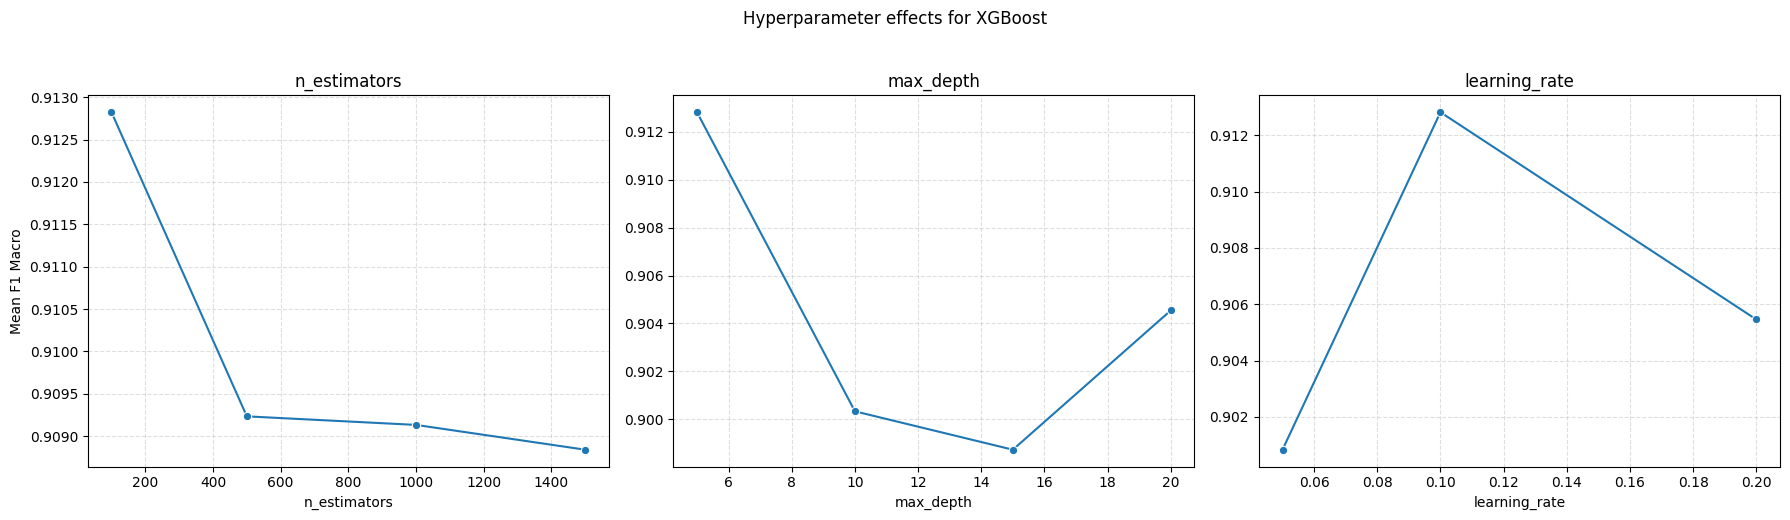

In [101]:
plot_hyperparameter_effects(XGBoost_results, 'XGBoost', XGBoost_params, XGBoost_best_params)

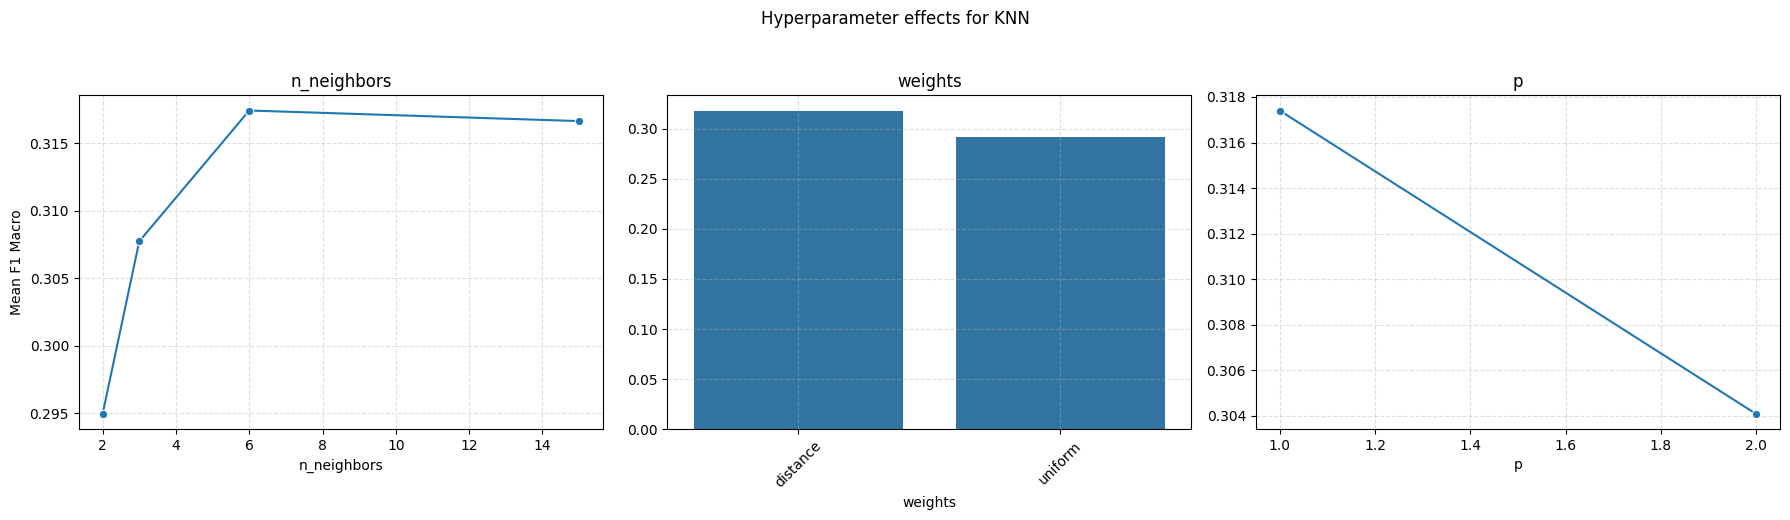

In [102]:
plot_hyperparameter_effects(KNN_results, 'KNN', KNN_params, KNN_best_params)

### 5.3 Best performing Model

In [103]:
print("Best Performing Models:")
print(f"Random Forest: F1 Macro = {randomForest_best['mean_test_f1_macro']:.4f}, Params = {randomForest_best_params}")
print(f"XGBoost: F1 Macro = {XGBoost_best['mean_test_f1_macro']:.4f}, Params = {XGBoost_best_params}")
print(f"KNN: F1 Macro = {KNN_best['mean_test_f1_macro']:.4f}, Params = {KNN_best_params}")

Best Performing Models:
Random Forest: F1 Macro = 0.9621, Params = {'n_estimators': np.int64(1000), 'max_depth': np.int64(10)}
XGBoost: F1 Macro = 0.9128, Params = {'n_estimators': np.int64(100), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1)}
KNN: F1 Macro = 0.3174, Params = {'n_neighbors': np.int64(6), 'weights': 'distance', 'p': np.int64(1)}


In [104]:
best_models = {
    'Random Forest': 
        (RandomForestClassifier(
            max_features=None,
            bootstrap=True,
            criterion='entropy',
            oob_score=True,
            n_jobs=-1,
            random_state=42,
            **randomForest_best_params), randomForest_best_params),
    'XGBoost': 
        (XGBClassifier(
            objective='multi:softprob',
            eval_metric='mlogloss',
            n_jobs=-1,
            random_state=42,
            **XGBoost_best_params), XGBoost_best_params),
    'KNN': (KNeighborsClassifier(**KNN_best_params), KNN_best_params)
}
for model_name, (model, params) in best_models.items():
    print(f"Training and evaluating best {model_name} model...")
    scale_TF = model_name.lower().startswith('knn')  # Scale only for KNN
    pipe = Pipeline(steps=[
        ('preprocessor', make_preprocessor(scale=scale_TF)),
        ('classifier', model)
    ])
    y_fit = y_train_int if (task == 'multiclass' and model_requires_int_labels(model_name)) else y_train
    pipe.fit(X_train, y_fit)

    y_val_pred = pipe.predict(X_val)
    if task == 'multiclass' and model_requires_int_labels(model_name):
        y_val_pred = pd.Series(y_val_pred).map(int_to_grade).values

    print(f"Test Classification Report for {model_name}:\n")
    print(classification_report(y_val, y_val_pred, zero_division=0))
    print("-" * 80)

Training and evaluating best Random Forest model...
Test Classification Report for Random Forest:

              precision    recall  f1-score   support

           A       1.00      0.99      1.00       364
           B       0.99      1.00      1.00       576
           C       1.00      0.99      1.00       598
           D       0.99      0.99      0.99       290
           E       0.98      0.95      0.96       124
           F       0.90      0.95      0.92        37
           G       0.91      0.91      0.91        11

    accuracy                           0.99      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.99      0.99      0.99      2000

--------------------------------------------------------------------------------
Training and evaluating best XGBoost model...
Test Classification Report for XGBoost:

              precision    recall  f1-score   support

           A       1.00      0.99      1.00       364
           B       0.99    

In [105]:
best_models["Random Forest"]

(RandomForestClassifier(criterion='entropy', max_depth=np.int64(10),
                        max_features=None, n_estimators=np.int64(1000),
                        n_jobs=-1, oob_score=True, random_state=42),
 {'n_estimators': np.int64(1000), 'max_depth': np.int64(10)})

### 5.4 Test effect of Scaling with KNN using top Hyperparameters

In [106]:
knn_wo_scaling = Pipeline(steps=[
    ('preprocessor', make_preprocessor(scale=False)),
    ('classifier', KNeighborsClassifier(**KNN_best_params))
])
y_fit = y_train_int
knn_wo_scaling.fit(X_train, y_fit)

y_val_pred = knn_wo_scaling.predict(X_val)
if task == 'multiclass' and model_requires_int_labels("KNN"):
    y_val_pred = pd.Series(y_val_pred).map(int_to_grade).values

print(f"Test Classification Report for KNN:\n")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("-" * 80)

Test Classification Report for KNN:

              precision    recall  f1-score   support

           A       0.36      0.35      0.36       364
           B       0.31      0.38      0.34       576
           C       0.34      0.38      0.36       598
           D       0.27      0.19      0.22       290
           E       0.15      0.06      0.08       124
           F       0.12      0.03      0.04        37
           G       0.00      0.00      0.00        11

    accuracy                           0.32      2000
   macro avg       0.22      0.20      0.20      2000
weighted avg       0.30      0.32      0.31      2000

--------------------------------------------------------------------------------


## 6 Predict Kaggle Competition

In [112]:
#First submission:
# first_submission = RandomForestClassifier(
#     criterion='entropy', 
#     max_features=None, 
#     n_jobs=-1, 
#     oob_score=True, 
#     random_state=42,
#     n_estimators= np.int64(1000),
#     max_depth= np.int64(10))

#second submission
second_submission = RandomForestClassifier(
    criterion='entropy', 
    max_features=None, 
    n_jobs=-1, 
    oob_score=True, 
    random_state=42,
    n_estimators= np.int64(975),
    max_depth= np.int64(9))

In [113]:
best_model = "Random Forest"
#predict the test set with the best model
model, params = best_models[best_model]
print(f"Predicting test set with best model: {best_model}...")
pipe = Pipeline(steps=[
    ('preprocessor', make_preprocessor(False)),
    ('classifier', second_submission)
])
pipe.fit(X, y)
X_test = test_df.drop(['ID'], axis=1)
y_test_pred = pipe.predict(X_test)
# Save predictions
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'grade': y_test_pred
})
submission_file = f"{datafolder}/loan-10k.{best_model.replace(' ', '_')}_submission.csv"
submission_df.to_csv(submission_file, index=False)

Predicting test set with best model: Random Forest...


In [109]:
pipe

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 6.1 Some more Grid Search for Kaggle

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [110]:
task = 'multiclass'

# Try more extensive Random Forest hyperparameter tuning for competition
scoring = get_scorings(multiclass=(task == 'multiclass'))
refit_metric = "f1_macro"
configs = {
        'Random Forest Kaggle': {
            'model': RandomForestClassifier(
                max_features=None,
                bootstrap=True,
                criterion='entropy',
                oob_score=True,
                n_jobs=-1,
                random_state=42,
            ),
            'param_grid': {
                'n_estimators': [950, 975, 980, 990, 1000, 1010, 1025, 1050, 1100],
                'max_depth': [None, 9, 10, 11, 12],
            },
        }
    }

results_dir = "loan/gridsearch"
os.makedirs(results_dir, exist_ok=True)
rand_forest_results = []

for name, cfg in configs.items():
    print(f"Running Grid Search for {name}...")
    scale_TF = name.lower().startswith('knn')  # Scale only for KNN
    pipe = Pipeline(steps=[
        ('preprocessor', make_preprocessor(scale=scale_TF)),
        ('classifier', cfg['model'])
    ])

    param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        n_jobs=1,
        verbose=3,
        cv=5
    )

    y_fit = y_train_int if (task == 'multiclass' and model_requires_int_labels(name)) else y_train
    gs.fit(X_train, y_fit)

    # Save per-model CV results
    res_df = pd.DataFrame(gs.cv_results_)
    rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
    if rank_col is not None:
        res_df = res_df.sort_values(rank_col)
    res_df.insert(0, 'model', name)
    res_df.insert(1, 'scoring', refit_metric)
    res_df['preproc_scaled'] = scale_TF
    out_path = os.path.join(results_dir, f"{name.replace(' ', '_')}_cv_results_{refit_metric}.csv")
    res_df.to_csv(out_path, index=False)
    rand_forest_results.append(res_df)

    print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

    y_val_pred = gs.predict(X_val)
    if task == 'multiclass' and model_requires_int_labels(name):
        y_val_pred = pd.Series(y_val_pred).map(int_to_grade).values

    print(f"Validation Classification Report for {name}:\n")
    print(classification_report(y_val, y_val_pred, zero_division=0))
    print("-" * 80)


Running Grid Search for Random Forest Kaggle...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END classifier__max_depth=None, classifier__n_estimators=950; accuracy: (test=0.992) f1_macro: (test=0.950) precision_macro: (test=0.962) recall_macro: (test=0.940) total time=   7.9s
[CV 2/5] END classifier__max_depth=None, classifier__n_estimators=950; accuracy: (test=0.995) f1_macro: (test=0.979) precision_macro: (test=0.975) recall_macro: (test=0.985) total time=   8.2s
[CV 3/5] END classifier__max_depth=None, classifier__n_estimators=950; accuracy: (test=0.993) f1_macro: (test=0.972) precision_macro: (test=0.977) recall_macro: (test=0.967) total time=   8.0s
[CV 4/5] END classifier__max_depth=None, classifier__n_estimators=950; accuracy: (test=0.989) f1_macro: (test=0.953) precision_macro: (test=0.951) recall_macro: (test=0.955) total time=   8.2s
[CV 5/5] END classifier__max_depth=None, classifier__n_estimators=950; accuracy: (test=0.994) f1_macro: (test=0.985) p

BEST VALUES ARE NOT CHANGED!